In [ ]:
# 1. Import Organization
# Better organization of imports by category
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard

#Laod audio and extract feature
import librosa
from scipy.stats import skew, kurtosis

In [ ]:
# 2.Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    # Load data
    df = pd.read_csv(file_path)

    # Create label encoder for gender
    label_mapping = {'male': 1, 'female': 0}
    y = df['label'].map(label_mapping).values

    # Drop label column to standardize features
    X = df.drop('label', axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Note: only transform, not fit_transform

    # Reshape for RNN
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    return df, X_train_reshaped, X_test_reshaped, y_train, y_test,scaler

In [ ]:
# 3. \\Model Architecture
def create_rnn_model(input_shape, learning_rate=0.001):
    model = Sequential([
        # First RNN layer with batch normalization
        SimpleRNN(64, activation='relu', return_sequences=True,
                 input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.3),

        # Second RNN layer
        SimpleRNN(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.3),

        # Dense layers for classification
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Use Adam optimizer with specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model

In [ ]:
# 4. Training with Callbacks
def train_model(model, X_train, y_train, X_test, y_test):
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'best_model.keras',  # Change the filepath to end with '.keras'
        monitor='val_accuracy',
        save_best_only=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )


   # Extract training loss history
    training_loss_history = history.history['loss']  # All loss values for each epoch
    training_accuracy_history = history.history['accuracy']

    return history, training_loss_history, training_accuracy_history


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 5. Model Evaluation
def evaluate_model(model, X_test, y_test):
    # Make predictions
    predictions = model.predict(X_test)
    predictions_classes = (predictions > 0.5).astype(int).flatten()

    # Evaluate on test set
    loss, accuracy, AUC = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions_classes, target_names=["Class 0", "Class 1"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return predictions, predictions_classes, loss, accuracy


In [ ]:
import librosa

# Function to extract features from an audio file
def extract_features_from_audio(file_path, sr=22050):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=sr)

    # Extract features
    meanfreq = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    sd = np.std(y)
    median = np.median(y)
    Q25 = np.percentile(y, 25)
    Q75 = np.percentile(y, 75)
    IQR = Q75 - Q25
    skewness = skew(y)
    kurt_value = kurtosis(y)
    sp_ent = np.mean(librosa.feature.spectral_flatness(y=y))
    sfm = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    mode = np.argmax(np.bincount(y.astype(int)))  # Approximate mode
    centroid = meanfreq  # Already calculated above
    meanfun = np.mean(librosa.feature.zero_crossing_rate(y=y))
    minfun = np.min(librosa.feature.zero_crossing_rate(y=y))
    maxfun = np.max(librosa.feature.zero_crossing_rate(y=y))
    meandom = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    mindom = np.min(librosa.feature.spectral_rolloff(y=y, sr=sr))
    maxdom = np.max(librosa.feature.spectral_rolloff(y=y, sr=sr))
    dfrange = maxdom - mindom
    modindx = np.mean(librosa.amplitude_to_db(abs(librosa.stft(y))))

    # Combine all features into an array
    features = np.array([
        meanfreq, sd, median, Q25, Q75, IQR, skewness, kurt_value,
        sp_ent, sfm, mode, centroid, meanfun, minfun, maxfun,
        meandom, mindom, maxdom, dfrange, modindx
    ])

    return features


In [ ]:
# 6. Usage
if __name__ == "__main__":
    # Load and preprocess data
    data, X_train, X_test, y_train, y_test,scaler = load_and_preprocess_data('/content/voice.csv')

data.head()



,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
# get total samples
n_samples = len(data)
# get total male samples
n_male_samples = len(data[data['label'] == 'male'])
# get total female samples
n_female_samples = len(data[data['label'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 3168
Total male samples: 1584
Total female samples: 1584


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

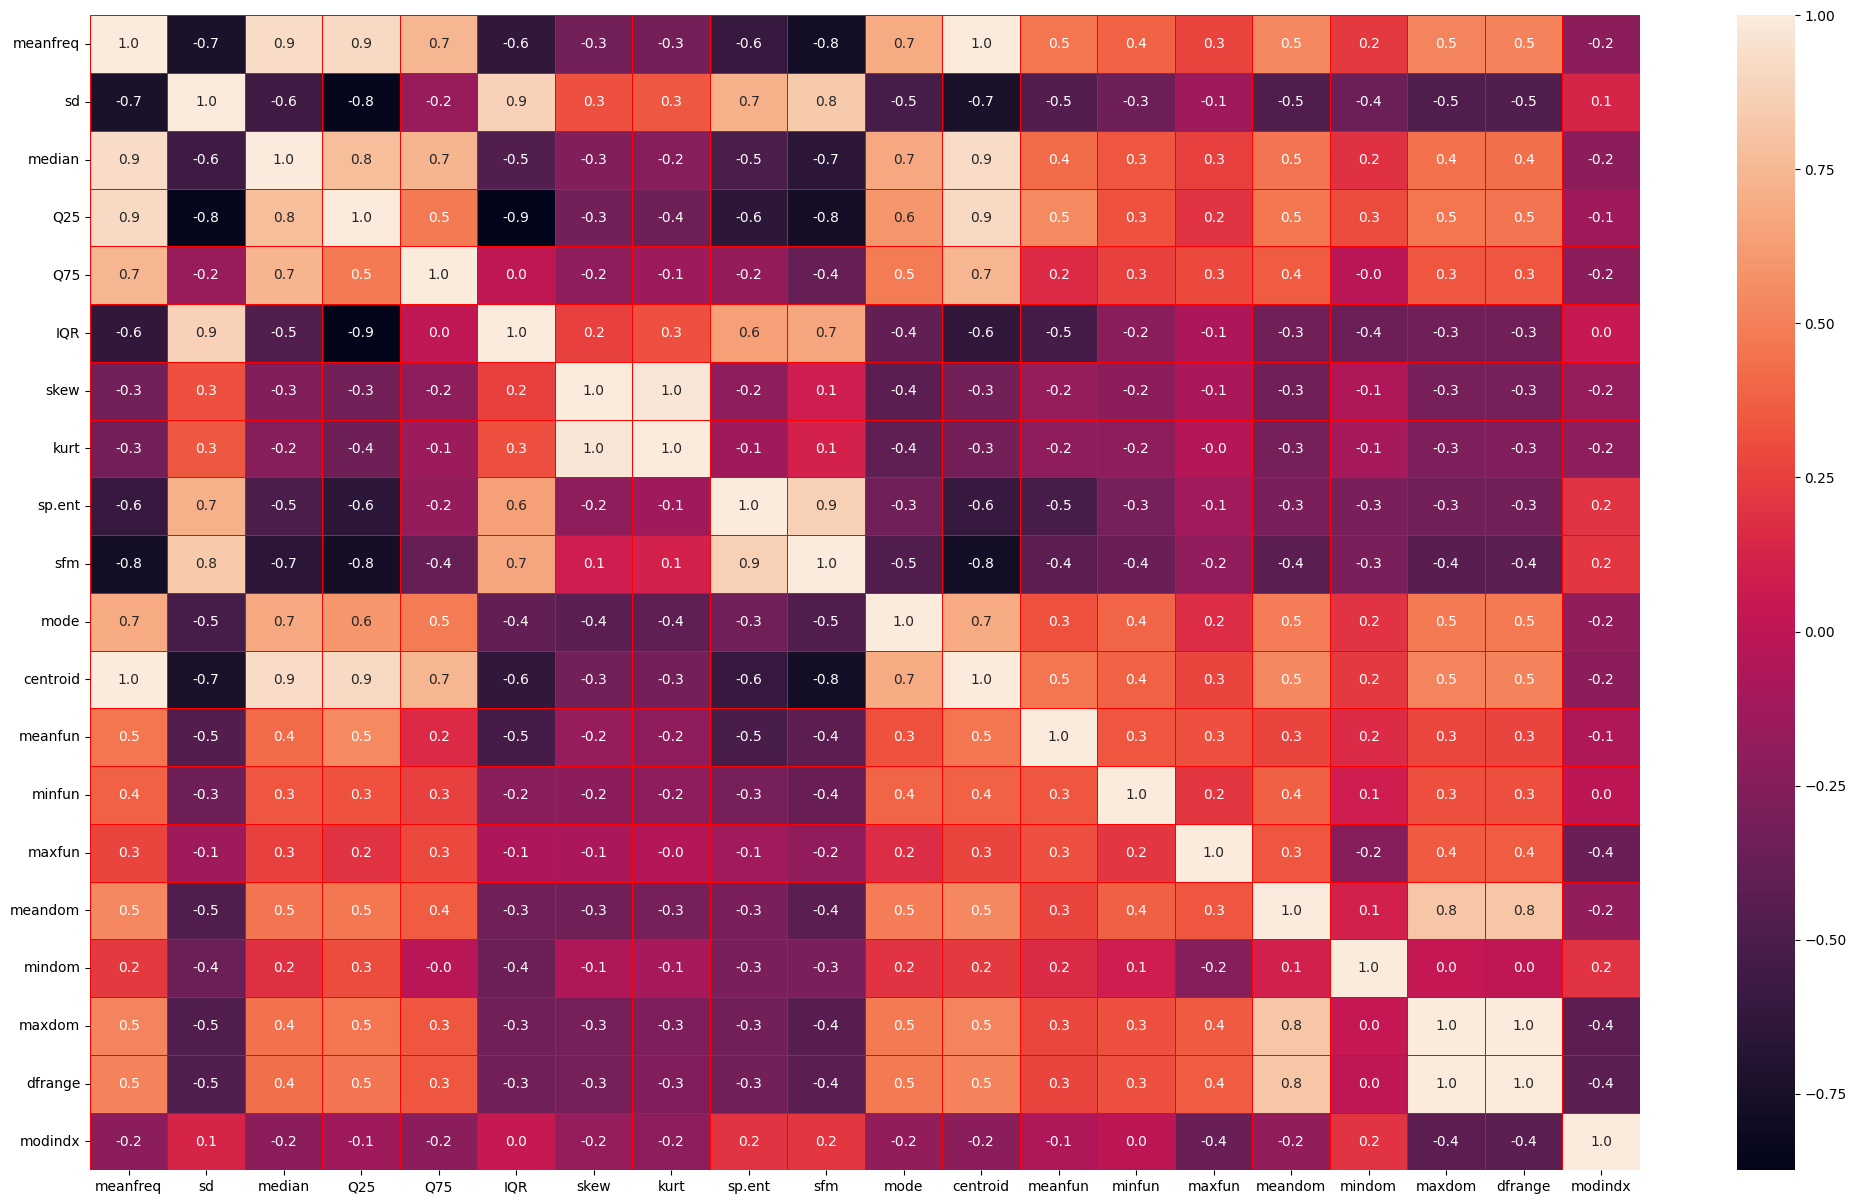

In [ ]:
 data.info() #gives you detailes about data types

 #identify relationships between numeric features in ower dataset by visualizing how strongly they are correlated
 numeric_columns = data.select_dtypes(include=[np.number])
 f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(numeric_columns.corr(), annot=True, linewidths=0.5, linecolor="red", fmt='.1f', ax=ax)
plt.show()

In [ ]:

    # Create and train model
    model = create_rnn_model(input_shape=(X_train.shape[1], 1))
    history, training_loss_history,training_accuracy = train_model(model, X_train, y_train, X_test, y_test)





Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5128 - auc_2: 0.5262 - loss: 0.8299 - val_accuracy: 0.5394 - val_auc_2: 0.7206 - val_loss: 0.6746
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7211 - auc_2: 0.7989 - loss: 0.5431 - val_accuracy: 0.7045 - val_auc_2: 0.8988 - val_loss: 0.5643
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8631 - auc_2: 0.9273 - loss: 0.3537 - val_accuracy: 0.6414 - val_auc_2: 0.9104 - val_loss: 0.5717
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9063 - auc_2: 0.9601 - loss: 0.2655 - val_accuracy: 0.9106 - val_auc_2: 0.9831 - val_loss: 0.2508
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9490 - auc_2: 0.9843 - loss: 0.1626 - val_accuracy: 0.9485 - val_auc_2: 0.9908 - val_loss: 0.1499
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9460 - auc_2: 0.9866 - loss: 0.1516 - val_accuracy: 0.9422 - val_auc_2: 0.9896 - val_loss: 0.1596
Epoch 7/100
70/70 ━━━━━━━━━━━━━

The final training loss value: 0.04922516271471977


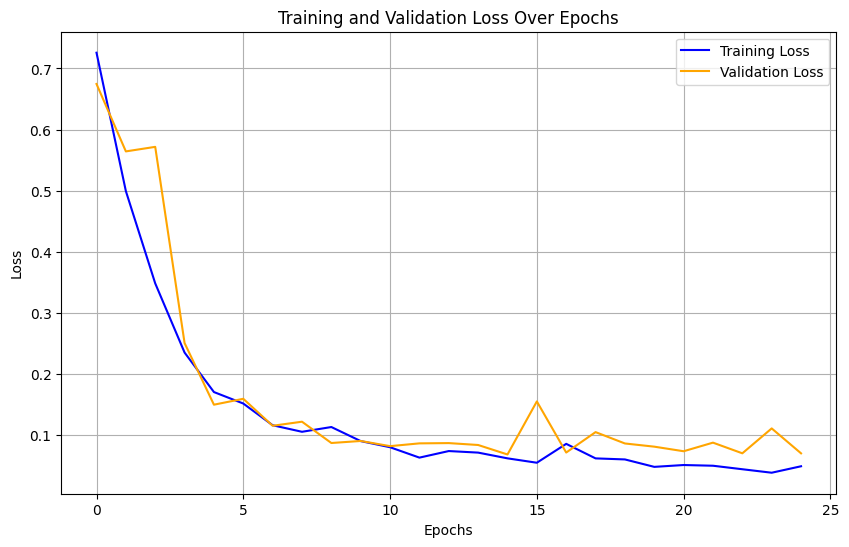

In [ ]:
print("The final training loss value:", training_loss_history[-1])

 # Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


The final training accuracy value: 0.9842128753662109


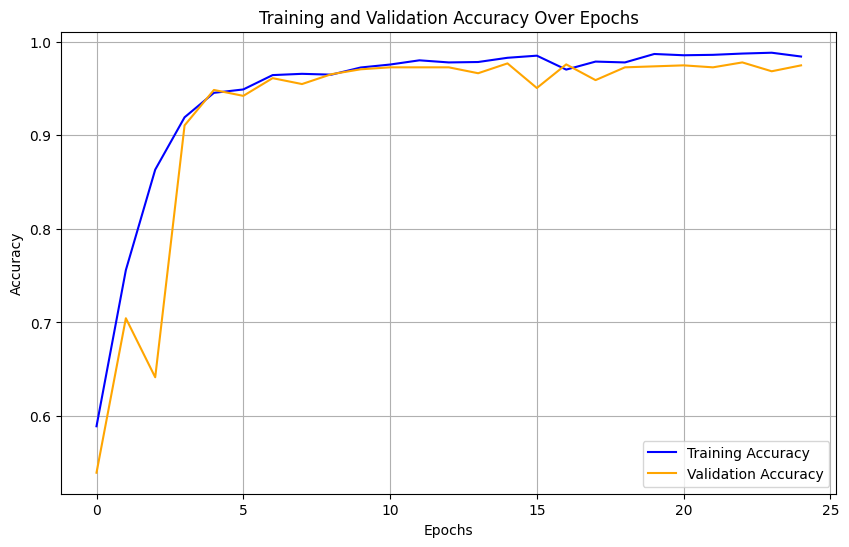

In [ ]:
print("The final training accuracy value:", training_accuracy[-1])

# Plot training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Test Loss: 0.0685
Test Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       452
     Class 1       0.98      0.97      0.98       499

    accuracy                           0.98       951
   macro avg       0.98      0.98      0.98       951
weighted avg       0.98      0.98      0.98       951



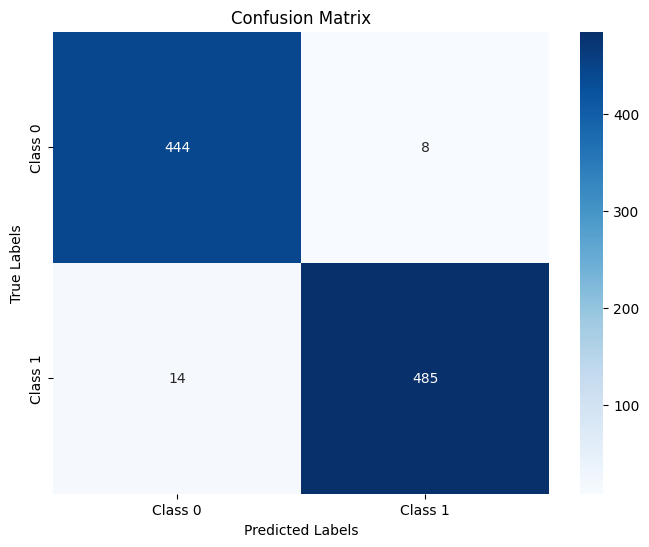

[0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1
 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0
 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1
 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1
 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0
 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1
 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1
 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1
 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1
 0 1 1 0 0 1 1 1 0 1 0 1 

In [ ]:
 # Evaluate model
predictions, predictions_classes,test_loss,test_accuracy= evaluate_model(model, X_test, y_test)
print(predictions_classes)


In [ ]:
#let's see if there is an overfitting
difference = test_loss - training_loss_history[-1]
print(f"The difference between the Training loss and the TEST loss: {difference:.5f}")
#A small difference between training and test loss generally indicates that your model is performing well
# and generalizing effectively to unseen data.

The difference between the Training loss and the TEST loss: 0.01928


In [ ]:
model.save("results/model.h5")

In [ ]:
# Load and preprocess the audio

audio_file_path = '/content/Record(2)) (online-audio-converter.com).mp3'  # Replace with your audio path
features = extract_features_from_audio(audio_file_path)
print(features)
# Standardize features (use the scaler from training)
features_scaled = scaler.transform([features])

# Reshape for RNN input (1 sample, number of features, 1 channel)
features_reshaped = features_scaled.reshape((1, features_scaled.shape[1], 1))

# Predict using the trained model
prediction = model.predict(features_reshaped)
predicted_class = 'male' if prediction > 0.5 else 'female'
print(f"Predicted Gender: {predicted_class}")

[ 3.34995542e+03  2.39049457e-02 -5.22324053e-14 -6.37422269e-03
  6.30433764e-03  1.26785603e-02 -1.74417234e-01  1.07327739e+01
  2.06342787e-02  2.86831327e+03  0.00000000e+00  3.34995542e+03
  1.73353168e-01  1.80664062e-02  8.26660156e-01  6.54514325e+03
  5.70629883e+02  1.01744385e+04  9.60380859e+03 -3.29814491e+01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Gender: female


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

